In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stat
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import pickle
from sklearn.metrics import *
import pandas as pd
import seaborn as sns
sns.set_theme()
import statsmodels

In [2]:
from all_models import *
#from transfer_models import *

In [3]:
# read fit values
fits_single = pickle.load(open('fit_single_CV_704.pickle', 'rb'))
fits_dual = pickle.load(open('fit_dual_CV_704.pickle', 'rb'))
fits_six = pickle.load(open('fit_six_CV_704.pickle', 'rb'))
fits_mixed = pickle.load(open('fit_mixed_CV_704.pickle', 'rb'))
fits_single_transfer = pickle.load(open('fit_single_CV_transfer.pickle', 'rb'))
fits_dual_transfer = pickle.load(open('fit_dual_CV_transfer.pickle', 'rb'))

curvatures_smooth = pickle.load(open('curvatures_smooth.pickle', 'rb'))
curvatures_smooth = curvatures_smooth/90.0
curvatures = pickle.load(open('curvatures.pickle', 'rb'))

In [4]:
def plot_data_vs_fits_dual(curvatures_smooth, Af, Bf, As, Bs):
    plt.figure(figsize = (20, 10))
    errors_predict = np.zeros((60, 704))
    fast = np.zeros((60, 704))
    slow = np.zeros((60, 704))
    rotation_est = np.zeros((60, 704))
    corr_coef = np.zeros(60)
    for participant in range(60):
        if participant % 4 == 0 or participant%4 == 1:
            errors_predict[participant], rotation_est[participant], fast[participant], slow[participant] = dual_model_sudden(704, Af[participant], Bf[participant], As[participant], Bs[participant])
            corr_coef[participant] = np.ma.corrcoef(errors_predict[participant], np.ravel(curvatures_smooth[participant])[64:])[0, 1]
        else:    
            errors_predict[participant], rotation_est[participant], fast[participant], slow[participant] = dual_model_gradual(704, Af[participant], Bf[participant], As[participant], Bs[participant])
            corr_coef[participant] = np.ma.corrcoef(errors_predict[participant], np.ravel(curvatures_smooth[participant])[64:])[0, 1]

    fig, ax = plt.subplots(4, dpi = 300, sharex = True, constrained_layout = True, figsize = (25, 15))
    plt.setp(ax, ylim=(-1, 2))
    legend_size = 15
    for participant in range(4):
        if participant%4 == 0  or participant%4 == 1:
            #plt.plot(np.nanmean(errors_predict[participant::4], axis = 0))
            l1, = ax[participant].plot(np.nanmean(rotation_est[participant::4], axis = 0))
            l2, = ax[participant].plot(np.nanmean(fast[participant::4], axis = 0))
            l3, = ax[participant].plot(np.nanmean(slow[participant::4], axis = 0))
            l4, = ax[participant].plot(np.append(np.ravel(np.nanmean(1 - curvatures_smooth[participant::4], axis = 0)[1:-1]), np.ravel(np.nanmean(curvatures_smooth[participant::4], axis = 0)[11])))
            ax[participant].legend([l1, l2, l3, l4], ['Rotation Est', 'Fast Est', 'Slow Est', 'Rotation Est Data'], prop={'size': legend_size})
        else:
            l1, = ax[participant].plot(np.nanmean(rotation_est[participant::4], axis = 0))
            l2, = ax[participant].plot(np.nanmean(fast[participant::4], axis = 0))
            l3, = ax[participant].plot(np.nanmean(slow[participant::4], axis = 0))
            cs = np.zeros((704))
            csm = np.nanmean(curvatures_smooth[participant::4], axis = 0)
            for i in range(9):
                cs[i*64:(i+1)*64] = (i+1)*10/90.0 - csm[i+1]
            cs[576:640] = 1 - csm[10]
            cs[640:] = csm[11]
            l4, = ax[participant].plot(cs)
            #plt.plot(np.append(np.ravel(np.nanmean(90 - curvatures_smooth[participant::4], axis = 0)[1:-1]), -np.ravel(np.nanmean(curvatures_smooth[participant::4], axis = 0)[11])))
            ax[participant].legend([l1, l2, l3, l4], ['Rotation Est', 'Fast Est', 'Slow Est', 'Rotation Est Data'], prop = {'size' : legend_size})


        ax[participant].plot(np.zeros(704), color = 'black')
        ax[0].set_ylabel('Sudden \n Speed', fontsize = 15)
        ax[1].set_ylabel('Sudden \n Accuracy', fontsize = 15)
        ax[2].set_ylabel('Gradual \n Speed', fontsize = 15)
        ax[3].set_ylabel('Gradual \n Accuracy', fontsize = 15)
    fig.suptitle('Dual Model Predictions', fontsize = 20)
    return corr_coef


In [5]:
plot_data_vs_fits_dual(curvatures_smooth, fits_dual[:, 0], fits_dual[:, 1], fits_dual[:, 2], fits_dual[:, 3])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
def plot_data_vs_fits_single(curvatures_smooth, A, B):
    plt.figure(figsize = (20, 10))
    errors_predict = np.zeros((60, 704))
    fast = np.zeros((60, 704))
    slow = np.zeros((60, 704))
    rotation_est = np.zeros((60, 704))
    corr_coef = np.zeros(60)
    for participant in range(60):
        if participant % 4 == 0 or participant%4 == 1:
            errors_predict[participant], rotation_est[participant] = model_sudden(704, A[participant], B[participant])
            corr_coef[participant] = np.ma.corrcoef(errors_predict[participant], np.ravel(curvatures_smooth[participant])[64:])[0, 1]
        else:    
            errors_predict[participant], rotation_est[participant] = model_gradual(704, A[participant], B[participant])
            corr_coef[participant] = np.ma.corrcoef(errors_predict[participant], np.ravel(curvatures_smooth[participant])[64:])[0, 1]

    fig, ax = plt.subplots(4, dpi = 300, sharex = True, constrained_layout = True, figsize = (25, 15))
    plt.setp(ax, ylim=(-1, 2))
    legend_size = 15
    
    for participant in range(4):
        if participant%4 == 0  or participant%4 == 1:
            #plt.plot(np.nanmean(errors_predict[participant::4], axis = 0))
            l1, = ax[participant].plot(np.nanmean(rotation_est[participant::4], axis = 0))
            l4, = ax[participant].plot(np.append(np.ravel(np.nanmean(1 - curvatures_smooth[participant::4], axis = 0)[1:-1]), np.ravel(np.nanmean(curvatures_smooth[participant::4], axis = 0)[11])))
            ax[participant].legend([l1, l4], ['Rotation Est', 'Rotation Est Data'], prop={'size': legend_size})
        else:
            l1, = ax[participant].plot(np.nanmean(rotation_est[participant::4], axis = 0))
            cs = np.zeros((704))
            csm = np.nanmean(curvatures_smooth[participant::4], axis = 0)
            for i in range(9):
                cs[i*64:(i+1)*64] = (i+1)*10/90.0 - csm[i+1]
            cs[576:640] = 1 - csm[10]
            cs[640:] = csm[11]
            l4, = ax[participant].plot(cs)
            #plt.plot(np.append(np.ravel(np.nanmean(90 - curvatures_smooth[participant::4], axis = 0)[1:-1]), -np.ravel(np.nanmean(curvatures_smooth[participant::4], axis = 0)[11])))
            ax[participant].legend([l1, l4], ['Rotation Est', 'Rotation Est Data'], prop = {'size' : legend_size})


        ax[participant].plot(np.zeros(704), color = 'black')
        ax[0].set_ylabel('Sudden \n Speed', fontsize = 15)
        ax[1].set_ylabel('Sudden \n Accuracy', fontsize = 15)
        ax[2].set_ylabel('Gradual \n Speed', fontsize = 15)
        ax[3].set_ylabel('Gradual \n Accuracy', fontsize = 15)
    fig.suptitle('Single state model predictions', fontsize = 20)
    return corr_coef


In [6]:
plot_data_vs_fits_single(curvatures_smooth, fits_single[:, 0], fits_single[:, 1])

NameError: name 'plot_data_vs_fits_single' is not defined

In [7]:
num_trials = 704
model_errors_dual = np.zeros((100, 60, num_trials))
model_errors_single = np.zeros((100, 60, num_trials))
model_errors_mixed = np.zeros((100, 60, num_trials))
model_errors_six = np.zeros((100, 60, num_trials))
model_errors_single_transfer = np.zeros((100, 60, 64))
model_errors_dual_transfer = np.zeros((100, 60, 64))
fast_est = pickle.load(open('fast_est.pickle', 'rb'))
slow_est = pickle.load(open('slow_est.pickle', 'rb'))

for i in range(100):
    for participant in range(60):
        if participant%4 == 0 or participant%4 == 1:
            model_errors_dual[i][participant]  = dual_model_sudden(num_trials, fits_dual[i][participant][0], fits_dual[i][participant][1], fits_dual[i][participant][2], fits_dual[i][participant][3])[0]
            model_errors_single[i][participant] = model_sudden(num_trials, fits_single[i][participant][0], fits_single[i][participant][1])[0]
            #model_errors_mixed[i][participant] = mixed_sudden(num_trials, fits_mixed[i][participant][0], fits_mixed[i][participant][1], fits_mixed[i][participant][2], fits_mixed[i][participant][3])[0]
            #model_errors_six[i][participant] = dual_six_param_sudden(num_trials, fits_six[i][participant][0], fits_six[i][participant][1], fits_six[i][participant][2], fits_six[i][participant][3], fits_six[i][participant][4], fits_six[i][participant][5])[0]
            #model_errors_six[i][participant]  = dual_six_param_sudden(num_trials, fits_dual[i][participant][0], fits_dual[i][participant][1], fits_dual[i][participant][0], fits_dual[i][participant][1], fits_dual[i][participant][2], fits_dual[i][participant][3])[0]
        
        else:
            model_errors_dual[i][participant] = dual_model_gradual(num_trials, fits_dual[i][participant][0], fits_dual[i][participant][1], fits_dual[i][participant][2], fits_dual[i][participant][3])[0]
            model_errors_single[i][participant] = model_gradual(num_trials, fits_single[i][participant][0], fits_single[i][participant][1])[0]
            #model_errors_mixed[i][participant] = mixed_gradual(num_trials, fits_mixed[i][participant][0], fits_mixed[i][participant][1], fits_mixed[i][participant][2], fits_mixed[i][participant][3])[0]
            #model_errors_six[i][participant] = dual_six_param_gradual(num_trials, fits_six[i][participant][0], fits_six[i][participant][1], fits_six[i][participant][2], fits_six[i][participant][3], fits_six[i][participant][4], fits_six[i][participant][5])[0]
            #model_errors_six[i][participant]  = dual_six_param_gradual(num_trials, fits_dual[i][participant][0], fits_dual[i][participant][1], fits_dual[i][participant][0], fits_dual[i][participant][1], fits_dual[i][participant][2], fits_dual[i][participant][3])[0]
        #model_errors_single_transfer[i][participant]  = single_transfer(64, fits_single_transfer[i][participant][0], fits_single_transfer[i][participant][1], 1 - np.nanmean(curvatures_smooth[participant][10][-16:]))
        #model_errors_dual_transfer[i][participant]  = dual_transfer( 64, fits_dual_transfer[i][participant][0], fits_dual_transfer[i][participant][1], fits_dual_transfer[i][participant][2], fits_dual_transfer[i][participant][3], [fast_est[i][participant], slow_est[i][participant]])


In [8]:
ll_dual = np.zeros((100, 60, 704))
ll_single = np.zeros((100, 60, 704))
ll_mix = np.zeros((100, 60, 704))
ll_six = np.zeros((100, 60, 704))
ll_single_transfer = np.zeros((100, 60, 64))
ll_dual_transfer = np.zeros((100, 60, 64))

for i in range(100):
    for participant in range(60):
        #ll_dual_transfer[i][participant] = stat.norm.logpdf(np.ravel(curvatures_smooth[participant][-1]), model_errors_dual_transfer[i][participant], fits_dual_transfer[i][participant, -2])
        #ll_single_transfer[i][participant] = stat.norm.logpdf(np.ravel(curvatures_smooth[participant][-1]), model_errors_single_transfer[i][participant], fits_single_transfer[i][participant, -2])

        ll_dual[i][participant] = stat.norm.logpdf(np.ravel(curvatures_smooth[participant][1:]), model_errors_dual[i][participant], fits_dual[i][participant, -2])
        ll_single[i][participant] = stat.norm.logpdf(np.ravel(curvatures_smooth[participant][1:]), model_errors_single[i][participant], fits_single[i][participant, -2])
        #ll_mix[i][participant] = stat.norm.logpdf(np.ravel(curvatures_smooth[participant][1:]), model_errors_mixed[i][participant], fits_mixed[i][participant, -2])
        #ll_six[i][participant] = stat.norm.logpdf(np.ravel(curvatures_smooth[participant][1:]), model_errors_six[i][participant], fits_six[i][participant, -2])
        #ll_six[i][participant] = stat.norm.logpdf(np.ravel(curvatures_smooth[participant][1:]), model_errors_six[i][participant], fits_dual[i][participant, -2])



In [9]:
ll_dual_combined = np.concatenate((ll_dual, ll_dual_transfer), axis = 2)
ll_single_combined = np.concatenate((ll_single, ll_single_transfer), axis = 2)


In [10]:
def get_lls(fits, ll, rotate):
    ll_rotate_train = np.zeros((100, 60))
    ll_transfer_train = np.zeros((100, 60))
    ll_rotate_test = np.zeros((100, 60))
    ll_transfer_test = np.zeros((100, 60))
    ll_all_test = np.zeros((100, 60))
    ll_all_train = np.zeros((100, 60))

    for i in range(100):
        for participant in range(60):
            rotate_train_indices = fits[i][participant, -1][fits[i][participant, -1] < 640]
            transfer_train_indices = fits[i][participant, -1][fits[i][participant, -1] >= 640]
            
            all_test_indices = np.delete(range(704), fits[i][participant, -1])
            rotate_test_indices = all_test_indices[all_test_indices<640]
            transfer_test_indices = all_test_indices[all_test_indices>=640]
            #if rotate:
            ll_rotate_train[i][participant] = sum(ll[i][participant][rotate_train_indices])
            ll_rotate_test[i][participant] = sum(ll[i][participant][rotate_test_indices])
            #else:
            ll_transfer_train[i][participant] = sum(ll[i][participant][transfer_train_indices])
            ll_transfer_test[i][participant] = sum(ll[i][participant][transfer_test_indices])
            #Uncomment for combined rotate + transfer
            ll_all_test[i][participant] = sum(ll[i][participant][all_test_indices])
            ll_all_train[i][participant] = sum(ll[i][participant][fits[i][participant, -1]])
    return [ll_rotate_train, ll_rotate_test, ll_transfer_train, ll_transfer_test, ll_all_train, ll_all_test]

In [11]:
dual_rotate_lls = get_lls(fits_dual, ll_dual, 1)
single_rotate_lls = get_lls(fits_single, ll_single, 1)
dual_transfer_lls = get_lls(fits_dual, ll_dual_transfer, 0)
single_transfer_lls = get_lls(fits_single, ll_single_transfer, 0)


IndexError: index 225 is out of bounds for axis 0 with size 64

In [9]:
dual_lls = [dual_rotate_lls[0], dual_rotate_lls[1], dual_transfer_lls[2], dual_transfer_lls[3]]
single_lls = [single_rotate_lls[0], single_rotate_lls[1], single_transfer_lls[2], single_transfer_lls[3]]


In [12]:
dual_lls = get_lls(fits_dual, ll_dual, 0)
single_lls = get_lls(fits_single, ll_single, 0)

In [ ]:
dual_lls[]

In [187]:
dual_lls[0][1][21], single_lls[0][1][21]


(638.5598993525963, 553.5034879834016)

In [13]:
def get_full_split_df(ll_selected, ll_compared, selected_model):
    d = {'Rotation': np.ravel(np.row_stack((np.repeat('Sudden', 120), np.repeat('Gradual', 120)))),
         'Emphasis': np.ravel(np.row_stack((np.repeat('Speed', 60), np.repeat('Accuracy', 60), np.repeat('Speed', 60), np.repeat('Accuracy', 60)))),
         'Phase': np.ravel(np.row_stack((np.repeat('Rotate', 30), np.repeat('Transfer', 30), np.repeat('Rotate', 30), np.repeat('Transfer', 30), np.repeat('Rotate', 30), np.repeat('Transfer', 30), np.repeat('Rotate', 30), np.repeat('Transfer', 30)))),
         'Set': np.ravel(np.row_stack((np.repeat('Train', 15), np.repeat('Test', 15), np.repeat('Train', 15), np.repeat('Test', 15), np.repeat('Train', 15), np.repeat('Test', 15), np.repeat('Train', 15), np.repeat('Test', 15), (np.repeat('Train', 15), np.repeat('Test', 15), np.repeat('Train', 15), np.repeat('Test', 15), np.repeat('Train', 15), np.repeat('Test', 15), np.repeat('Train', 15), np.repeat('Test', 15)))))}
    df = pd.DataFrame(d)

    df[selected_model] = np.concatenate((
    sum(ll_compared[0][:, 0::4] <= ll_selected[0][:, 0::4]), 
    sum(ll_compared[1][:, 0::4] <= ll_selected[1][:, 0::4]),
    sum(ll_compared[2][:, 0::4] <= ll_selected[2][:, 0::4]),
    sum(ll_compared[3][:, 0::4] <= ll_selected[3][:, 0::4]),

    sum(ll_compared[0][:, 1::4] <= ll_selected[0][:, 1::4]), 
    sum(ll_compared[1][:, 1::4] <= ll_selected[1][:, 1::4]),
    sum(ll_compared[2][:, 1::4] <= ll_selected[2][:, 1::4]),
    sum(ll_compared[3][:, 1::4] <= ll_selected[3][:, 1::4]),

    sum(ll_compared[0][:, 2::4] <= ll_selected[0][:, 2::4]), 
    sum(ll_compared[1][:, 2::4] <= ll_selected[1][:, 2::4]),
    sum(ll_compared[2][:, 2::4] <= ll_selected[2][:, 2::4]),
    sum(ll_compared[3][:, 2::4] <= ll_selected[3][:, 2::4]),

    sum(ll_compared[0][:, 3::4] <= ll_selected[0][:, 3::4]), 
    sum(ll_compared[1][:, 3::4] <= ll_selected[1][:, 3::4]),
    sum(ll_compared[2][:, 3::4] <= ll_selected[2][:, 3::4]),
    sum(ll_compared[3][:, 3::4] <= ll_selected[3][:, 3::4])
    ))
    return df

In [14]:
def get_train_test_split(ll_selected, ll_compared, model_selected):
    d = {'Rotation': np.ravel(np.row_stack((np.repeat('Sudden', 60), np.repeat('Gradual', 60)))),
     'Emphasis': np.ravel(np.row_stack((np.repeat('Speed', 30), np.repeat('Accuracy', 30), np.repeat('Speed', 30), np.repeat('Accuracy', 30)))),
     'Set': np.ravel(np.row_stack((np.repeat('Train', 15), np.repeat('Test', 15), np.repeat('Train', 15), np.repeat('Test', 15), np.repeat('Train', 15), np.repeat('Test', 15), np.repeat('Train', 15), np.repeat('Test', 15))))}
    df = pd.DataFrame(d)
    df[model_selected] = np.concatenate((
    sum(ll_compared[4][:, 0::4] <= ll_selected[4][:, 0::4]), 
    sum(ll_compared[5][:, 0::4] <= ll_selected[5][:, 0::4]),

    sum(ll_compared[4][:, 1::4] <= ll_selected[4][:, 1::4]), 
    sum(ll_compared[5][:, 1::4] <= ll_selected[5][:, 1::4]),

    sum(ll_compared[4][:, 2::4] <= ll_selected[4][:, 2::4]), 
    sum(ll_compared[5][:, 2::4] <= ll_selected[5][:, 2::4]),

    sum(ll_compared[4][:, 3::4] <= ll_selected[4][:, 3::4]), 
    sum(ll_compared[5][:, 3::4] <= ll_selected[5][:, 3::4]),
    ))
    return df

In [15]:
df_full_split = get_full_split_df(dual_lls, single_lls, "Dual_Selected")
df_train_test = get_train_test_split(dual_lls, single_lls, "Dual_Selected")

Text(0.5, 0.98, 'Compared to Single')

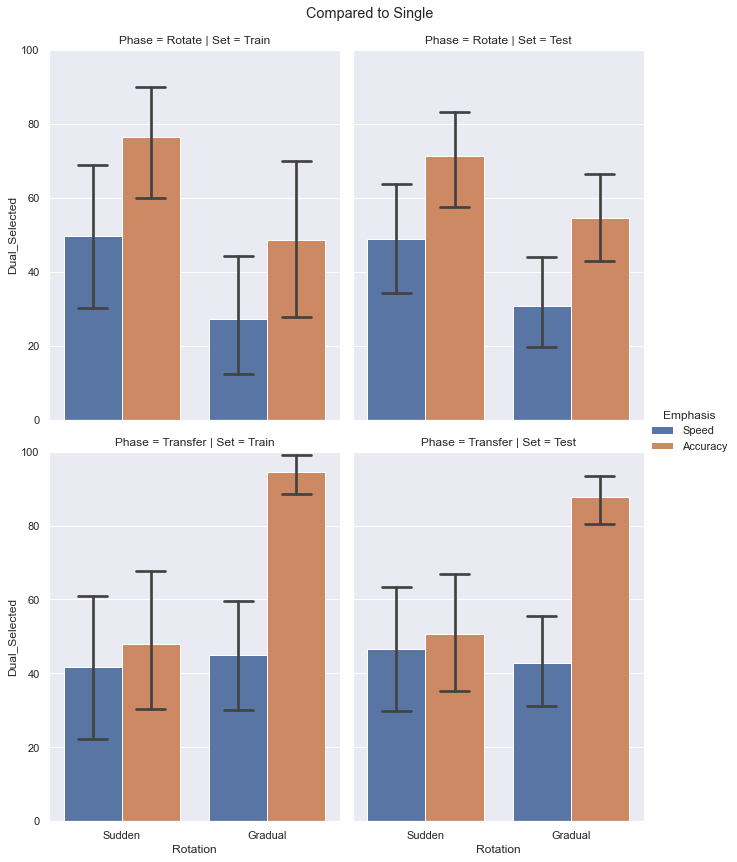

In [16]:
g = sns.catplot(x="Rotation", y="Dual_Selected", hue="Emphasis", col="Set", row = "Phase",
                capsize=.2, height=6, aspect=.75,ci = 95,
                kind = 'bar', data=df_full_split)
plt.subplots_adjust(top=0.93)
plt.ylim((0, 100))
g.fig.suptitle('Compared to Single')


Text(0.5, 0.98, 'Compared to Single')

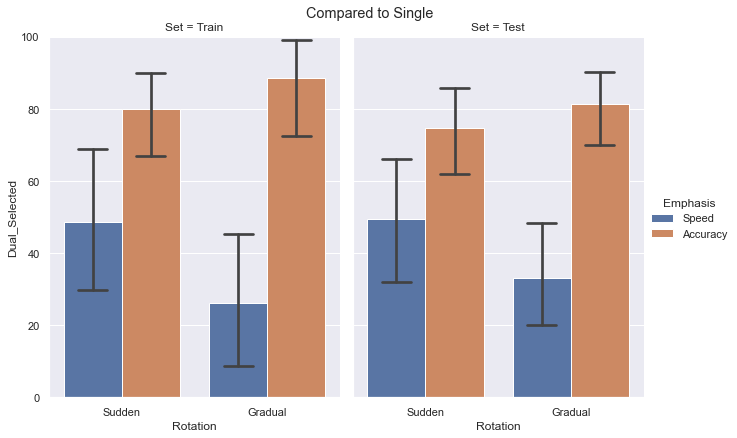

In [17]:
g = sns.catplot(x="Rotation", y="Dual_Selected", hue="Emphasis", col="Set", 
                capsize=.2, height=6, aspect=.75,ci = 95,
                kind = 'bar', data=df_train_test)
plt.subplots_adjust(top=0.91)
plt.ylim((0, 100))
g.fig.suptitle('Compared to Single')


In [22]:
model = smf.ols('Dual_Selected ~ Rotation*Emphasis', data=df_train_test[df_full_split['Set'] == 'Test']).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

<ipython-input-22-eaf9e1bd1fa4>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  model = smf.ols('Dual_Selected ~ Rotation*Emphasis', data=df_train_test[df_full_split['Set'] == 'Test']).fit()


,sum_sq,df,F,PR(>F)
Rotation,340.816667,1.0,0.454873,0.502805
Emphasis,20276.816667,1.0,27.062560,0.000003
Rotation:Emphasis,2006.816667,1.0,2.678408,0.107326
Residual,41958.400000,56.0,NaN,NaN


In [23]:
SS = df_train_test['Dual_Selected'][df_train_test['Set'] == 'Test'][df_train_test['Emphasis'] == 'Speed'][df_train_test['Rotation'] == 'Sudden']
GS = df_train_test['Dual_Selected'][df_train_test['Set'] == 'Test'][df_train_test['Emphasis'] == 'Speed'][df_train_test['Rotation'] == 'Gradual']
SA = df_train_test['Dual_Selected'][df_train_test['Set'] == 'Test'][df_train_test['Emphasis'] == 'Accuracy'][df_train_test['Rotation'] == 'Sudden']
GA = df_train_test['Dual_Selected'][df_train_test['Set'] == 'Test'][df_train_test['Emphasis'] == 'Accuracy'][df_train_test['Rotation'] == 'Gradual']


In [24]:
statsmodels.stats.proportion.proportions_chisquare([np.mean(SS), np.mean(SG), np.mean(AS), np.mean(AG)],[100, 100, 100, 100])

NameError: name 'SG' is not defined

In [154]:
SA

45    59
46    72
47    95
48    55
49    93
50    94
51    97
52    64
53    52
54    81
55    99
56    11
57    88
58    70
59    88
Name: Dual_Selected, dtype: int32

C:\Users\Tejas\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: autodetected range of [-inf, 2.0] is not finite

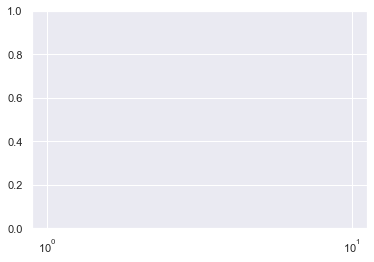

In [52]:
sns.histplot(data = df_train_test, x = 'Dual_Selected', hue = 'Emphasis',log_scale=True)

In [115]:
np.mean(curvatures_smooth[0::4, 11, -16:], axis = 1)

array([0.03635145, 0.21088737, 0.07010521, 0.24181661, 0.72199026,
       0.19491832, 0.15040447, 0.09073866, 0.64726762, 0.08942074,
       0.02113171, 0.0976869 , 0.03686975, 0.0766792 , 0.32894058])

(-1.0, 1.0)

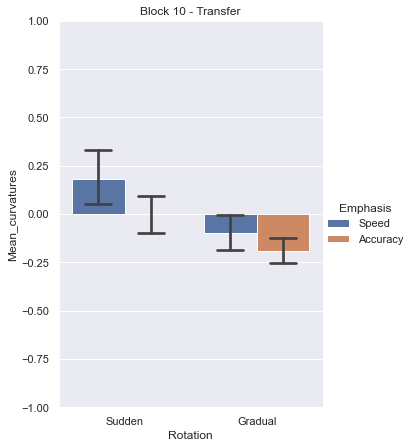

In [139]:
block = 11
d = {'Rotation': np.ravel(np.row_stack((np.repeat('Sudden', 30), np.repeat('Gradual', 30)))),
     'Emphasis': np.ravel(np.row_stack((np.repeat('Speed', 15), np.repeat('Accuracy', 15), np.repeat('Speed', 15), np.repeat('Accuracy', 15)))),
     
    'Mean_curvatures': np.concatenate((np.mean(curvatures_smooth[0::4], axis = 2)[:, block-1] - np.mean(curvatures_smooth[0::4], axis = 2)[:, block],
                np.mean(curvatures_smooth[1::4], axis = 2)[:, block-1] - np.mean(curvatures_smooth[1::4], axis = 2)[:, block],
                np.mean(curvatures_smooth[2::4], axis = 2)[:, block-1] - np.mean(curvatures_smooth[2::4], axis = 2)[:, block],
                np.mean(curvatures_smooth[3::4], axis = 2)[:, block-1] - np.mean(curvatures_smooth[3::4], axis = 2)[:, block],
             ))

    }

df_last_rotate = pd.DataFrame(d)
g = sns.catplot(x="Rotation", y="Mean_curvatures", hue="Emphasis",
                capsize=.2, height=6, aspect=.75,ci = 95,
                kind = 'bar', data=df_last_rotate)
plt.title('Block 10 - Transfer')
plt.ylim((-1, 1))

In [140]:
model = smf.ols('Mean_curvatures ~ Rotation*Emphasis', data=df_last_rotate).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
Rotation,0.821691,1.0,18.930433,0.000058
Emphasis,0.282815,1.0,6.515604,0.013447
Rotation:Emphasis,0.031229,1.0,0.719476,0.399927
Residual,2.430727,56.0,NaN,NaN


In [95]:
np.mean(df_last_rotate['Mean_curvatures'][46:60])

-0.17998015909867204

In [151]:
a, b = stats.chisquare([GS, GA, SS, SA])

array([88.4       , 17.61643836, 70.19806763, 10.90797546, 32.59036145,
       54.28571429, 47.72151899, 11.47770701, 48.03971119,  9.67701863,
       29.75409836, 12.34680135, 17.83387622, 55.20216606, 26.39649123])

Text(0.5, 1.0, 'Rotate')

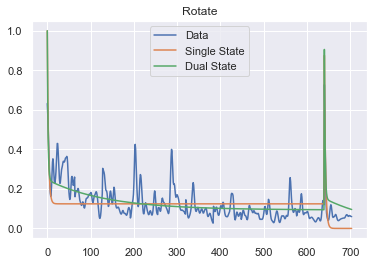

In [155]:
participant = 41
itr = 22
p0, = plt.plot(np.ravel(curvatures_smooth[participant][1:]))
p1, = plt.plot(model_errors_single[itr][participant])
p2, = plt.plot(model_errors_dual[itr][participant])
plt.legend((p0, p1, p2), ('Data', 'Single State', 'Dual State'))
plt.title('Rotate')

Text(0.5, 1.0, 'Transfer')

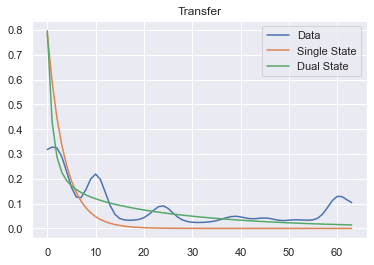

In [48]:
participant = 37

p0, = plt.plot(np.ravel(curvatures_smooth[participant][-1]))
p1, = plt.plot(np.mean(model_errors_single_transfer, axis = 0)[participant])
p2, = plt.plot(np.mean(model_errors_dual_transfer, axis = 0)[participant])

plt.legend((p0, p1, p2), ('Data', 'Single State', 'Dual State'))
plt.title('Transfer')

In [49]:
curvatures_smooth[participant][10][-1]

0.8514456500218309

In [32]:
participant = 53
fits_single_transfer[1][participant][2], fits_dual_transfer[1][participant][4]

(-16.286725535895798, -7.450671493772525)

In [38]:
participant = 14
-2*np.sum(stat.norm.logpdf(curvatures_smooth[participant][-1], model_errors_dual_transfer[0][participant]))

121.11122410290955

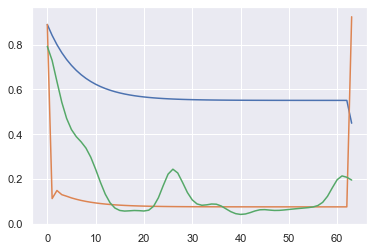

In [164]:
plt.plot(model_transfer(0.89, 64, 0.9210593053638314, 0.06433684145450244)[0])
plt.plot(dual_transfer(0.89, 64, 0.7135521829308, 0.49866691606443314, 0.9526619783821537, 0.4986667586384563,)[0])

plt.plot(curvatures_smooth[participant][-1])

In [158]:
1 - curvatures_smooth[participant][10][-1]

0.8995634881336975

In [117]:
its = pickle.load(open('params/its.pickle', 'rb'))
mts = pickle.load(open('mts.pickle', 'rb'))

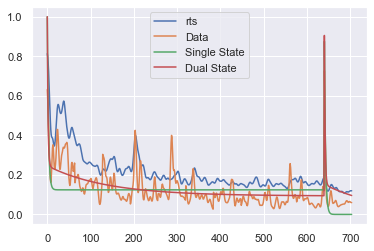

In [157]:
participant = 41
p, = plt.plot(gaussian_filter1d(np.ravel( (mts[participant][1:])/np.max(mts[participant]) + its[20][1:]/np.max(its[participant])), sigma = 3))
#plt.plot(np.ravel(curvatures_smooth[participant][1:]))
p0, = plt.plot(np.ravel(curvatures_smooth[participant][1:]))
p1, = plt.plot(model_errors_single[itr][participant])
p2, = plt.plot(model_errors_dual[itr][participant])
plt.legend((p, p0, p1, p2), ('rts', 'Data', 'Single State', 'Dual State'))


50.24349663838527

In [47]:
fits_dual[0, 5]

10.503401873917536

In [49]:
fits_single[0, 3]

-82.73038327528457

93.2337851492021